In [1]:
#Import ML Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set up the path for the data
data_path = "./_MensData/"

In [3]:
# Pre-Analysis of dataset
tourney_data = pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv")
regular_season_data = pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv")

#Print dataset dimensions and head
print(tourney_data.shape)
print(regular_season_data.shape)
regular_season_data.head()

(1382, 34)
(118882, 34)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


### Determine Baseline Accuracy Values:
Add seeding to each team and get accuracy score for predicting higher seeded team to win each game
and 50/50 split for teams with same seed

In [4]:
# Determine ground truth: from 2003-2024 if we predicted the higher seeded team to win in the tournament what would be our accurracy
tourney_detailed = pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv")

#Get tournament seeds from 2003 to 2024 (we only have detailed data for these seasons)
tourney_seeds = pd.read_csv(data_path + "MNCAATourneySeeds.csv")
tourney_seeds = tourney_seeds[(tourney_seeds['Season'] <= 2024) & (tourney_seeds['Season'] >= 2003)]
#print(tourney_seeds)

#concatenate winning and losing team seed values to tourney_detailed
tourney_seeds = tourney_seeds.rename(columns={'TeamID': 'WTeamID', 'Seed': 'WSeed'})
tourney_detailed = tourney_detailed.merge(tourney_seeds[['Season', 'WTeamID', 'WSeed']], on=['Season', 'WTeamID'], how='left')
tourney_seeds = tourney_seeds.rename(columns={'WTeamID': 'LTeamID', 'WSeed': 'LSeed'})
tourney_detailed = tourney_detailed.merge(tourney_seeds[['Season', 'LTeamID', 'LSeed']], on=['Season', 'LTeamID'], how='left')

#determine correct predictions where higher seeded team wins
correct_predictions = 0
total_predictions = 0
sub_prediction = 0
for _, row in tourney_detailed.iterrows(): 
    
    #Get integer seed values
    winning_seed = int(''.join(filter(str.isdigit, str(row["WSeed"]))))
    losing_seed = int(''.join(filter(str.isdigit, str(row["LSeed"]))))

    #Check if the higher-seeded team won
    if winning_seed < losing_seed:  
        correct_predictions += 1  # Higher seed won
    elif winning_seed == losing_seed: #if the seeds are the same we'll do a 50/50 win loss split
        correct_predictions += sub_prediction
        sub_prediction = 1 - sub_prediction
    total_predictions += 1
        
# Print accuracy percentage and concatenated dataset
print(f"Prediction Accuracy: {correct_predictions/total_predictions:.2%}")
#tourney_detailed.sample(10)

Prediction Accuracy: 69.68%


### Add Desired Metrics to Regular Season Dataset:
Add gameresult metric to dataset and create differentials of regular season statistics that will later be merged onto our tournament dataset

In [5]:
#Adjust regular season data to include a teams seed, efg%, and other key metrics
df_season_results = pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv")

# List of columns
cols = ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

#Define reshape vals for columns
winning_team_reshape_cols = [col for col in cols if col != "LTeamID"]
losing_team_reshape_cols = [col for col in cols if col != "WTeamID"]
win_pairs = dict()
lose_pairs = dict()

# Process columns for winning team
for col in winning_team_reshape_cols:
    if col == "WLoc":
        win_pairs[col] = "Location"
    elif col != "WTeamID" and col[0] == 'W':
        new_col = col.replace("W", "Team")
        win_pairs[col] = new_col
    elif col != "WTeamID" and col[0] == 'L':
        new_col = col.replace("L", "Opp")
        win_pairs[col] = new_col
    elif col == "WTeamID":
        win_pairs[col] = "TeamID"
    else:
        win_pairs[col] = col

# Process columns for losing team
for col in losing_team_reshape_cols:
    if col == "WLoc":
        lose_pairs[col] = "Location"
    elif col != "LTeamID" and col[0] == 'L':
        new_col = col.replace("L", "Team")
        lose_pairs[col] = new_col
    elif col != "LTeamID" and col[0] == 'W':
        new_col = col.replace("W", "Opp")
        lose_pairs[col] = new_col
    elif col == "LTeamID":
        lose_pairs[col] = "TeamID"
    else:
        lose_pairs[col] = col

#Output result (for testing purposes)
#print("Winning Team Column Mapping:", win_pairs)
#print("Losing Team Column Mapping:", lose_pairs)

#Add whether team won to DF and concatenate losing teams to the bottom
df_team_season_results = pd.concat(
    [
        df_season_results[winning_team_reshape_cols]
        .assign(GameResult="W")
        .rename(
            columns=win_pairs
        ),
        df_season_results[losing_team_reshape_cols]
        .assign(GameResult="L")
        .rename(
            columns=lose_pairs
        ),
    ]
).reset_index(drop=True)

if df_team_season_results.isna().any().any():
    print("There are NaN values in the DataFrame.")

#Create seasonal features
df_team_season_results["ScoreDiff"] = (
    df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]
)
df_team_season_results.drop(["TeamScore", "OppScore"], axis=1, inplace=True)
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype(
    "int"
)

#Print sample from new csv file
print(df_team_season_results.shape) #should have 2x as many rows as MRegularSeasonDetailed.csv
df_team_season_results.sample(10, random_state=10)

(237764, 34)


,Season,DayNum,TeamID,Location,NumOT,TeamFGM,TeamFGA,TeamFGM3,TeamFGA3,TeamFTM,...,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,ScoreDiff,Win
17641,2006,107,1406,H,0,20,42,8,19,11,...,11,17,14,9,6,2,13,W,2,1
85773,2019,93,1283,H,0,21,44,6,19,17,...,10,21,5,9,3,0,18,W,6,1
223449,2023,68,1130,A,0,26,63,6,17,6,...,8,24,15,15,4,7,9,L,-1,0
237762,2025,132,1206,N,0,19,56,9,21,16,...,11,25,10,16,7,9,20,L,-5,0
208714,2020,62,1259,H,0,25,54,4,20,17,...,9,22,20,11,8,2,20,L,-7,0
200385,2018,117,1379,H,0,16,54,2,19,10,...,6,34,9,10,6,4,19,L,-29,0
29031,2009,14,1338,H,0,32,54,7,17,11,...,12,18,8,13,8,1,18,W,29,1
209721,2020,84,1458,H,0,24,64,8,28,6,...,13,33,10,9,2,7,15,L,-6,0
192318,2017,62,1268,A,0,23,65,11,25,8,...,14,29,10,15,11,5,24,L,-2,0
171570,2013,75,1236,A,0,24,47,2,8,9,...,9,21,7,17,3,4,19,L,-4,0


In [6]:
#Create aggregate of features for each team we're interested in
#Results should be 1 row for each unique team we're interested in per season
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID"])
    .agg(
        MedianScoreDiff=("ScoreDiff", "median"),
        WinPercentage=("Win", "mean"),
        TeamMedFGM=("TeamFGM", "median"),
        TeamMedFGA=("TeamFGA", "median"),
        TeamMedFGM3=("TeamFGM3", "median"),
        TeamMedFGA3=("TeamFGA3", "median"),
        TeamMedFTM=("TeamFTM", "median"),
        TeamMedFTA=("TeamFTA", "median"),
        TeamMedOR=("TeamOR", "median"),
        TeamMedDR=("TeamDR", "median"),
        TeamMedAst=("TeamAst", "median"),
        TeamMedTO=("TeamTO", "median"),
        TeamMedStl=("TeamStl", "median"),
        TeamMedBlk=("TeamBlk", "median"),
        TeamMedPF=("TeamPF", "median"),
    )
    .reset_index()
)

#Add the teams seed going into the tournament as a metric for our data aswell, fill teams that don't make the playoffs with value 20
playoff_seed = pd.read_csv(data_path + "MNCAATourneySeeds.csv")
playoff_seed["SeedAdjusted"] = (
    playoff_seed["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)
playoff_seed.drop(["Seed"], axis=1, inplace=True)
team_season_agg = team_season_agg.merge(
    playoff_seed, on=["Season", "TeamID"], how="left"
)
team_season_agg["SeedAdjusted"].fillna(20, inplace=True)

#The total number of unique teams per season should be the same as our aggregated data
unique_teams_per_season = df_team_season_results.groupby("Season")["TeamID"].nunique()
assert sum(unique_teams_per_season) == len(team_season_agg)

# Check for duplicates in the Season and TeamID columns
duplicates = team_season_agg[team_season_agg.duplicated(subset=["Season", "TeamID"])]
if not duplicates.empty:
    print("Found duplicates:")
    print(duplicates)
else:
    print("No duplicates found.")
    
nan_values = team_season_agg.isna().sum()
if nan_values.any():
    print("Found NaN values in the following columns:")
    print(nan_values[nan_values > 0])
else:
    print("No NaN values found.")
    
#Create a copy of these values for future use
team_season_stats = team_season_agg.copy()

#Print aggregated team data sample
team_season_agg.sample(10, random_state=600)

No duplicates found.
No NaN values found.


,Season,TeamID,MedianScoreDiff,WinPercentage,TeamMedFGM,TeamMedFGA,TeamMedFGM3,TeamMedFGA3,TeamMedFTM,TeamMedFTA,TeamMedOR,TeamMedDR,TeamMedAst,TeamMedTO,TeamMedStl,TeamMedBlk,TeamMedPF,SeedAdjusted
1689,2008,1144,-5.0,0.310345,25.0,56.0,6.0,19.0,17.0,23.0,12.0,23.0,15.0,18.0,7.0,2.0,21.0,20.0
7964,2025,1464,4.0,0.593750,25.5,58.5,8.0,27.0,15.5,21.5,9.0,22.5,13.0,12.0,6.0,5.0,18.5,20.0
3860,2014,1242,9.0,0.727273,28.0,56.0,5.0,16.0,19.0,26.0,11.0,25.0,15.0,12.0,6.0,5.0,22.0,2.0
5542,2019,1168,-7.0,0.451613,25.0,55.0,5.0,17.0,15.0,20.0,8.0,28.0,12.0,13.0,5.0,3.0,19.0,20.0
6440,2021,1374,5.0,0.687500,26.5,59.5,8.0,21.0,15.0,18.0,9.0,25.5,14.5,13.5,5.5,4.0,18.0,20.0
6818,2022,1396,3.0,0.586207,22.0,56.0,6.0,21.0,15.0,22.0,10.0,24.0,12.0,13.0,6.0,4.0,18.0,20.0
4516,2016,1195,2.0,0.551724,29.0,59.0,5.0,14.0,13.0,20.0,11.0,28.0,12.0,11.0,6.0,4.0,19.0,16.0
23,2003,1128,3.5,0.653846,21.5,50.0,7.5,20.5,15.5,23.5,10.0,19.5,13.0,15.0,8.0,3.5,18.0,20.0
6584,2022,1157,-1.0,0.480000,25.0,57.0,7.0,19.0,12.0,16.0,9.0,25.0,12.0,13.0,6.0,3.0,16.0,20.0
1510,2007,1314,15.5,0.823529,31.0,62.0,6.0,15.0,16.0,24.5,13.0,27.0,18.0,12.5,8.0,5.0,17.0,1.0


In [7]:
#Verify our aggregate is correct by finding the median blocks for yale mens basketball in 2016 from our
#original df and seeing whether it matches the aggregate

regular_season_df = pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv")

# Find Yale blocks per game - create a copy explicitly
yale_2025 = regular_season_df[(regular_season_df['Season'] == 2016) & 
                             ((regular_season_df['WTeamID'] == 1463) | (regular_season_df['LTeamID'] == 1463))].copy()

# Calculate blocks for Yale in each game
yale_2025['total_blocks'] = yale_2025.apply(
    lambda row: row['WBlk'] if row['WTeamID'] == 1463 else row['LBlk'], axis=1)

# Calculate the median blocks per game
yale_average_blocks_per_game = yale_2025['total_blocks'].median()

# Compare with aggregated data
assert yale_average_blocks_per_game == team_season_agg.loc[
    (team_season_agg["Season"] == 2016) & 
    (team_season_agg["TeamID"] == 1463), 
    "TeamMedBlk"
].item()

### Create Tournament Dataset and Add Regular Season stats created above to it:
Create a tournament dataset with our desired columns, add each teams median stats to it (essentially we're grouping by season and teamid and adding the relevent info)

In [8]:
# Create a tournament dataframe we'll use to train our model on
# Similar to before we'll add a win target column
# We'll also add a location column, nvm I scrapped this because all games are played at neutral sites

df_tourney_results = pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv")
df_team_tourney_results = pd.concat(
    [
        df_tourney_results[
            ["Season", "WTeamID", "LTeamID", "WScore", "LScore"]
        ]
        .assign(GameResult="W")
        .rename(
            columns={
                "WTeamID": "TeamID",
                "LTeamID": "OppTeamID",
                "WScore": "TeamScore",
                "LScore": "OppScore",
            }
        ),
        df_tourney_results[
            ["Season", "LTeamID", "WTeamID", "LScore", "WScore"]
        ]
        .assign(GameResult="L")
        .rename(
            columns={
                "LTeamID": "TeamID",
                "WTeamID": "OppTeamID",
                "LScore": "TeamScore",
                "WScore": "OppScore",
            }
        ),
    ]
).reset_index(drop=True)

#Add win column w/ target output
df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype(
    "int"
)

#Drop Columns we aren't interested in and won't be training
df_team_tourney_results.drop(["TeamScore", "OppScore"], axis=1, inplace=True)
print(df_team_tourney_results)

#Size should be 2764 (Twice as much as the size of the MNCAATourneyDetailedResults.csv file
assert len(df_team_tourney_results) == 2764

      Season  TeamID  OppTeamID GameResult  Win
0       2003    1421       1411          W    1
1       2003    1112       1436          W    1
2       2003    1113       1272          W    1
3       2003    1141       1166          W    1
4       2003    1143       1301          W    1
...      ...     ...        ...        ...  ...
2759    2024    1181       1301          L    0
2760    2024    1397       1345          L    0
2761    2024    1104       1163          L    0
2762    2024    1301       1345          L    0
2763    2024    1345       1163          L    0

[2764 rows x 5 columns]


In [9]:
#Merge our tourney results with the individual data we gathered for each team
team_season_agg_cols = ['Season', 'TeamID', 'MedianScoreDiff', 'WinPercentage', 'TeamMedFGM',
       'TeamMedFGA', 'TeamMedFGM3', 'TeamMedFGA3', 'TeamMedFTM', 'TeamMedFTA',
       'TeamMedOR', 'TeamMedDR', 'TeamMedAst', 'TeamMedTO', 'TeamMedStl',
       'TeamMedBlk', 'TeamMedPF', 'SeedAdjusted']

merge_tournament_results = df_team_tourney_results.merge(
    team_season_agg[
        team_season_agg_cols
    ],
    on=["Season", "TeamID"],
    how="left",
).merge(
    team_season_agg[
        team_season_agg_cols
    ].rename(
        columns={
            "TeamID": "OppTeamID",
        }
    ),
    on=["Season", "OppTeamID"],
)

pd.set_option('display.max_columns', None)
print(merge_tournament_results.columns)
merge_tournament_results.head()

Index(['Season', 'TeamID', 'OppTeamID', 'GameResult', 'Win',
       'MedianScoreDiff_x', 'WinPercentage_x', 'TeamMedFGM_x', 'TeamMedFGA_x',
       'TeamMedFGM3_x', 'TeamMedFGA3_x', 'TeamMedFTM_x', 'TeamMedFTA_x',
       'TeamMedOR_x', 'TeamMedDR_x', 'TeamMedAst_x', 'TeamMedTO_x',
       'TeamMedStl_x', 'TeamMedBlk_x', 'TeamMedPF_x', 'SeedAdjusted_x',
       'MedianScoreDiff_y', 'WinPercentage_y', 'TeamMedFGM_y', 'TeamMedFGA_y',
       'TeamMedFGM3_y', 'TeamMedFGA3_y', 'TeamMedFTM_y', 'TeamMedFTA_y',
       'TeamMedOR_y', 'TeamMedDR_y', 'TeamMedAst_y', 'TeamMedTO_y',
       'TeamMedStl_y', 'TeamMedBlk_y', 'TeamMedPF_y', 'SeedAdjusted_y'],
      dtype='object')


,Season,TeamID,OppTeamID,GameResult,Win,MedianScoreDiff_x,WinPercentage_x,TeamMedFGM_x,TeamMedFGA_x,TeamMedFGM3_x,TeamMedFGA3_x,TeamMedFTM_x,TeamMedFTA_x,TeamMedOR_x,TeamMedDR_x,TeamMedAst_x,TeamMedTO_x,TeamMedStl_x,TeamMedBlk_x,TeamMedPF_x,SeedAdjusted_x,MedianScoreDiff_y,WinPercentage_y,TeamMedFGM_y,TeamMedFGA_y,TeamMedFGM3_y,TeamMedFGA3_y,TeamMedFTM_y,TeamMedFTA_y,TeamMedOR_y,TeamMedDR_y,TeamMedAst_y,TeamMedTO_y,TeamMedStl_y,TeamMedBlk_y,TeamMedPF_y,SeedAdjusted_y
0,2003,1421,1411,W,1,-3.0,0.448276,25.0,57.0,6.0,17.0,17.0,21.0,12.0,22.0,13.0,16.0,7.0,3.0,19.0,16.0,2.5,0.600000,25.0,55.0,5.5,19.0,17.5,28.0,12.5,24.5,14.0,15.0,6.0,2.0,19.0,16.0
1,2003,1112,1436,W,1,13.0,0.892857,30.0,66.0,7.0,19.5,17.0,25.0,15.0,26.0,18.5,14.5,8.0,4.0,17.5,1.0,6.0,0.655172,23.0,58.0,5.0,15.0,12.0,18.0,12.0,26.0,13.0,14.0,6.0,3.0,16.0,16.0
2,2003,1113,1272,W,1,5.0,0.620690,27.0,57.0,4.0,12.0,17.0,24.0,13.0,22.0,16.0,14.0,4.0,4.0,19.0,10.0,7.0,0.793103,26.0,61.0,8.0,20.0,16.0,24.0,13.0,25.0,17.0,13.0,7.0,4.0,18.0,7.0
3,2003,1141,1166,W,1,7.0,0.793103,28.0,53.0,7.0,18.0,19.0,24.0,11.0,24.0,15.0,18.0,7.0,3.0,21.0,11.0,13.0,0.878788,29.0,57.0,7.0,20.0,13.0,20.0,11.0,23.0,18.0,13.0,8.0,5.0,17.0,6.0
4,2003,1143,1301,W,1,7.0,0.724138,27.0,58.0,6.0,18.0,13.0,19.0,11.0,22.0,17.0,14.0,7.0,3.0,18.0,8.0,6.0,0.600000,23.5,52.0,8.0,21.5,15.0,19.0,10.0,21.0,14.0,14.0,7.5,2.0,18.0,9.0


### Create Differentials of our Median Statistics
Go through each game and essentially merge any similar columns into Teama-Teamb = diff columns

In [10]:
#Merge our cols into differentials (i.e. diff in seed, ft made, fta, diff in blks, etc.)

#Iterate through each column, if it ends with _x we want to find its _y counterpart and merge the two
merge_tournament_results_copy = merge_tournament_results.copy(deep=True)
for col in merge_tournament_results.columns:
    if col[-2:] == "_x":
        new_name = "Diff" + col[:-2]
        merge_tournament_results_copy[new_name] = (
            merge_tournament_results_copy[col[:-2] + "_x"] - 
            merge_tournament_results_copy[col[:-2] + "_y"]
        )
        merge_tournament_results_copy.drop([col[:-2] + "_x"], axis=1, inplace=True)
        merge_tournament_results_copy.drop([col[:-2] + "_y"], axis=1, inplace=True)

#Print original results
print(merge_tournament_results.shape)
merge_tournament_results.head()

(2764, 37)


,Season,TeamID,OppTeamID,GameResult,Win,MedianScoreDiff_x,WinPercentage_x,TeamMedFGM_x,TeamMedFGA_x,TeamMedFGM3_x,TeamMedFGA3_x,TeamMedFTM_x,TeamMedFTA_x,TeamMedOR_x,TeamMedDR_x,TeamMedAst_x,TeamMedTO_x,TeamMedStl_x,TeamMedBlk_x,TeamMedPF_x,SeedAdjusted_x,MedianScoreDiff_y,WinPercentage_y,TeamMedFGM_y,TeamMedFGA_y,TeamMedFGM3_y,TeamMedFGA3_y,TeamMedFTM_y,TeamMedFTA_y,TeamMedOR_y,TeamMedDR_y,TeamMedAst_y,TeamMedTO_y,TeamMedStl_y,TeamMedBlk_y,TeamMedPF_y,SeedAdjusted_y
0,2003,1421,1411,W,1,-3.0,0.448276,25.0,57.0,6.0,17.0,17.0,21.0,12.0,22.0,13.0,16.0,7.0,3.0,19.0,16.0,2.5,0.600000,25.0,55.0,5.5,19.0,17.5,28.0,12.5,24.5,14.0,15.0,6.0,2.0,19.0,16.0
1,2003,1112,1436,W,1,13.0,0.892857,30.0,66.0,7.0,19.5,17.0,25.0,15.0,26.0,18.5,14.5,8.0,4.0,17.5,1.0,6.0,0.655172,23.0,58.0,5.0,15.0,12.0,18.0,12.0,26.0,13.0,14.0,6.0,3.0,16.0,16.0
2,2003,1113,1272,W,1,5.0,0.620690,27.0,57.0,4.0,12.0,17.0,24.0,13.0,22.0,16.0,14.0,4.0,4.0,19.0,10.0,7.0,0.793103,26.0,61.0,8.0,20.0,16.0,24.0,13.0,25.0,17.0,13.0,7.0,4.0,18.0,7.0
3,2003,1141,1166,W,1,7.0,0.793103,28.0,53.0,7.0,18.0,19.0,24.0,11.0,24.0,15.0,18.0,7.0,3.0,21.0,11.0,13.0,0.878788,29.0,57.0,7.0,20.0,13.0,20.0,11.0,23.0,18.0,13.0,8.0,5.0,17.0,6.0
4,2003,1143,1301,W,1,7.0,0.724138,27.0,58.0,6.0,18.0,13.0,19.0,11.0,22.0,17.0,14.0,7.0,3.0,18.0,8.0,6.0,0.600000,23.5,52.0,8.0,21.5,15.0,19.0,10.0,21.0,14.0,14.0,7.5,2.0,18.0,9.0


In [11]:
#Print differentiated results
print(merge_tournament_results_copy.shape)

#Verify wins and losses (there should equally as many wins as losses since we duplicated the games)
assert (merge_tournament_results["GameResult"] == "W").sum() == (merge_tournament_results["GameResult"] == "L").sum()

merge_tournament_results_copy.sample(10, random_state = 10)

(2764, 21)


,Season,TeamID,OppTeamID,GameResult,Win,DiffMedianScoreDiff,DiffWinPercentage,DiffTeamMedFGM,DiffTeamMedFGA,DiffTeamMedFGM3,DiffTeamMedFGA3,DiffTeamMedFTM,DiffTeamMedFTA,DiffTeamMedOR,DiffTeamMedDR,DiffTeamMedAst,DiffTeamMedTO,DiffTeamMedStl,DiffTeamMedBlk,DiffTeamMedPF,DiffSeedAdjusted
981,2011,1140,1459,W,1,4.0,0.242424,2.0,4.0,2.0,10.0,3.0,2.0,1.0,4.0,1.0,0.0,1.0,1.0,-1.0,-11.0
955,2010,1388,1124,L,0,3.0,0.059140,0.5,0.5,1.0,2.5,-1.5,-3.0,-3.0,-1.0,2.0,-3.0,-1.0,-1.0,-2.0,7.0
543,2007,1166,1305,L,0,-3.0,-0.183468,-6.0,-7.0,-2.0,0.5,2.5,2.5,-2.0,-3.0,-3.0,-2.0,0.0,-1.5,0.0,3.0
2422,2023,1116,1242,W,1,0.0,-0.188057,-0.5,-3.5,-1.5,-5.0,4.5,5.5,-0.5,-2.0,-3.0,0.0,0.0,2.0,3.0,7.0
1722,2016,1372,1323,L,0,15.5,0.165179,-0.5,2.5,1.0,1.5,-2.0,0.0,0.5,-3.0,5.0,2.5,3.0,-1.0,5.5,8.0
709,2008,1211,1172,L,0,-4.0,-0.025202,-2.0,-5.5,-1.5,-7.0,4.5,7.0,-1.0,0.5,-2.0,2.0,0.0,1.0,-0.5,-3.0
2458,2023,1418,1397,L,0,-3.5,0.069697,3.0,-1.5,-1.0,-5.0,1.0,4.5,-1.5,-1.0,-2.0,1.0,-1.0,0.0,2.0,9.0
311,2005,1368,1329,L,0,-6.0,-0.089400,-5.0,-8.0,-3.0,-6.0,-1.0,0.0,-1.0,-3.0,-5.0,0.0,2.0,2.0,-2.0,13.0
608,2007,1272,1326,L,0,4.0,0.000000,3.0,7.0,0.0,3.0,3.0,8.0,4.0,1.0,0.0,2.0,4.0,0.0,7.0,1.0
1450,2014,1234,1397,L,0,-5.5,0.000000,5.0,6.0,-0.5,-0.5,3.0,3.0,-0.5,1.0,5.0,-0.5,1.5,0.5,0.0,0.0


### Add new features that account for differences in conference strength:
Add an averagetotalwins by conference feature and a conference representation feature

In [12]:
#Get the average total wins for each conference and append that to our dataset
#First merge team conferences on our merge_tournmanet_results_copy df
conference_df = pd.read_csv(data_path + "MTeamConferences.csv")

new_df = merge_tournament_results_copy.merge(conference_df, 
                                             on=["Season", "TeamID"],
                                             how="left")

#Create mapping of conferences 
season_conf_stats = new_df.groupby(["Season", "ConfAbbrev"]).agg(
    num_teams=('TeamID', 'nunique'),
    total_wins=('Win', 'sum')
).reset_index()

#Verify mapping worked by printing all the acc conf abbreviations (should be 21)
assert len(season_conf_stats.query("ConfAbbrev == 'acc'")) == 21

#Get avg total_wins for each conference
conf_avg_total_wins = season_conf_stats.groupby("ConfAbbrev")["total_wins"].mean().reset_index()
conf_avg_total_wins.rename(columns={"total_wins": "avg_total_wins"}, inplace=True)

print(conf_avg_total_wins)
#Merge avg_total_conf_wins into new_df
new_df = new_df.merge(conf_avg_total_wins, on="ConfAbbrev", how="left")
new_df.rename(columns={"avg_total_wins": "avg_total_conf_wins"}, inplace=True)

#Merge num_teams into new_df (on Season + ConfAbbrev)
new_df = new_df.merge(season_conf_stats[["Season", "ConfAbbrev", "num_teams"]],
                      on=["Season", "ConfAbbrev"], how="left")

#Check result
#print(new_df[["Season", "TeamID", "ConfAbbrev", "avg_total_conf_wins", "num_teams"]].head())

#Update training df with enriched version
merge_tournament_results_copy = new_df

#Our avg_total_conf_wins stat is saying, on average,
#the pac ten as a whole wins ~6 tournament games a season

#Verify our results by printing all listing for the pac_ten in 2004, should have only 3 unique teamids
new_df.query("Season == 2004 and ConfAbbrev == 'pac_ten'")

    ConfAbbrev  avg_total_wins
0        a_sun        0.238095
1        a_ten        2.095238
2          aac        2.700000
3          acc        9.761905
4          aec        0.190476
5     big_east        9.047619
6      big_sky        0.047619
7    big_south        0.190476
8      big_ten        8.714286
9   big_twelve        8.523810
10    big_west        0.285714
11         caa        0.666667
12        cusa        1.857143
13     horizon        1.000000
14         ivy        0.400000
15        maac        0.333333
16         mac        0.333333
17        meac        0.238095
18    mid_cont        0.200000
19         mvc        1.428571
20         mwc        1.380952
21         nec        0.380952
22         ovc        0.333333
23     pac_ten        5.777778
24  pac_twelve        5.500000
25     patriot        0.190476
26         sec        7.380952
27    southern        0.238095
28   southland        0.285714
29      summit        0.250000
30    sun_belt        0.333333
31      

,Season,TeamID,OppTeamID,GameResult,Win,DiffMedianScoreDiff,DiffWinPercentage,DiffTeamMedFGM,DiffTeamMedFGA,DiffTeamMedFGM3,DiffTeamMedFGA3,DiffTeamMedFTM,DiffTeamMedFTA,DiffTeamMedOR,DiffTeamMedDR,DiffTeamMedAst,DiffTeamMedTO,DiffTeamMedStl,DiffTeamMedBlk,DiffTeamMedPF,DiffSeedAdjusted,ConfAbbrev,avg_total_conf_wins,num_teams
134,2004,1390,1427,W,1,9.5,0.395238,3.0,-1.0,-2.0,-6.0,-2.0,-2.5,-1.0,-0.5,4.0,-3.5,0.0,2.0,-2.0,-15.0,pac_ten,5.777778,3
161,2004,1112,1371,L,0,0.0,0.011084,5.5,7.5,1.5,4.0,2.0,1.0,3.0,1.0,5.0,3.0,1.0,1.0,-1.0,1.0,pac_ten,5.777778,3
207,2004,1449,1412,L,0,-3.0,-0.056322,3.0,-2.0,1.0,-2.0,4.0,5.0,1.0,1.0,-1.5,2.5,-5.0,-1.5,0.0,-1.0,pac_ten,5.777778,3
214,2004,1390,1104,L,0,9.0,0.380460,2.0,0.0,-2.0,-4.0,-1.0,-1.0,-1.0,1.5,6.0,2.0,0.0,1.0,-2.0,-7.0,pac_ten,5.777778,3


In [13]:
#rename num_teams to be conf_representation
merge_tournament_results_copy.rename(columns={"num_teams" : "conf_representation"}, inplace=True)
merge_tournament_results_copy.sample(5, random_state=100)

,Season,TeamID,OppTeamID,GameResult,Win,DiffMedianScoreDiff,DiffWinPercentage,DiffTeamMedFGM,DiffTeamMedFGA,DiffTeamMedFGM3,DiffTeamMedFGA3,DiffTeamMedFTM,DiffTeamMedFTA,DiffTeamMedOR,DiffTeamMedDR,DiffTeamMedAst,DiffTeamMedTO,DiffTeamMedStl,DiffTeamMedBlk,DiffTeamMedPF,DiffSeedAdjusted,ConfAbbrev,avg_total_conf_wins,conf_representation
1752,2017,1211,1355,W,1,21.5,0.469697,4.5,1.5,-1.0,-5.0,-0.5,-2.5,0.0,5.0,4.0,-1.0,2.0,2.0,-1.0,-15.0,wcc,2.238095,2
1825,2017,1462,1112,W,1,-7.5,-0.264706,1.5,3.0,-1.0,4.0,-4.0,-2.0,0.0,-1.0,1.5,2.0,1.0,-1.0,0.5,9.0,big_east,9.047619,7
2465,2023,1266,1277,L,0,5.5,0.210626,3.0,4.5,1.0,5.5,2.0,3.0,0.5,-5.0,1.5,0.0,6.0,0.0,0.0,-5.0,big_east,9.047619,5
2416,2023,1388,1433,W,1,-1.5,-0.012868,1.5,4.0,2.0,2.5,-3.0,-3.0,0.5,1.0,0.0,-3.0,-2.0,-1.5,0.0,-7.0,wcc,2.238095,2
1690,2016,1218,1268,L,0,4.5,0.083333,-0.5,-1.0,0.0,2.0,2.0,4.0,1.0,-1.0,2.5,0.0,4.0,-1.5,4.5,8.0,big_west,0.285714,1


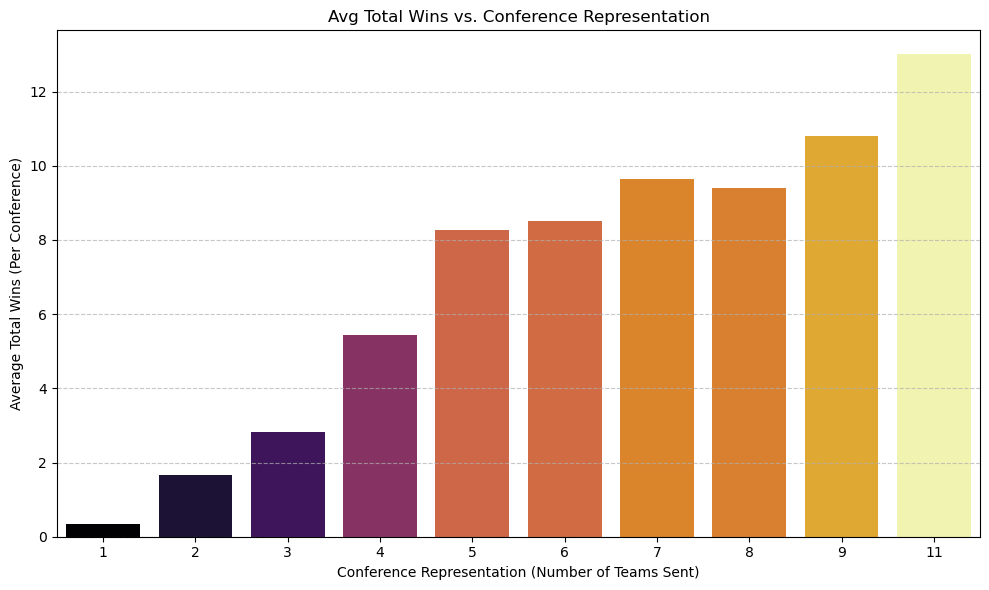

In [14]:
#plot respective conference representation

#group by Season and ConfAbbrev to get total wins and num teams per year
conf_season_stats = merge_tournament_results_copy.groupby(
    ["Season", "ConfAbbrev"]
).agg(
    total_wins=("Win", "sum"),
    conf_representation=("conf_representation", "first") 
).reset_index()

# group by conf_representation to get average total wins
rep_vs_avg_wins = conf_season_stats.groupby("conf_representation")["total_wins"].mean().reset_index()

# Create bounds for barplot with colors
norm = plt.Normalize(rep_vs_avg_wins["total_wins"].min(), rep_vs_avg_wins["total_wins"].max())
colors = plt.cm.inferno(norm(rep_vs_avg_wins["total_wins"]))

# Step 4: Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=rep_vs_avg_wins,
    x="conf_representation",
    y="total_wins",
    palette=colors
)

plt.xlabel("Conference Representation (Number of Teams Sent)")
plt.ylabel("Average Total Wins (Per Conference)")
plt.title("Avg Total Wins vs. Conference Representation")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

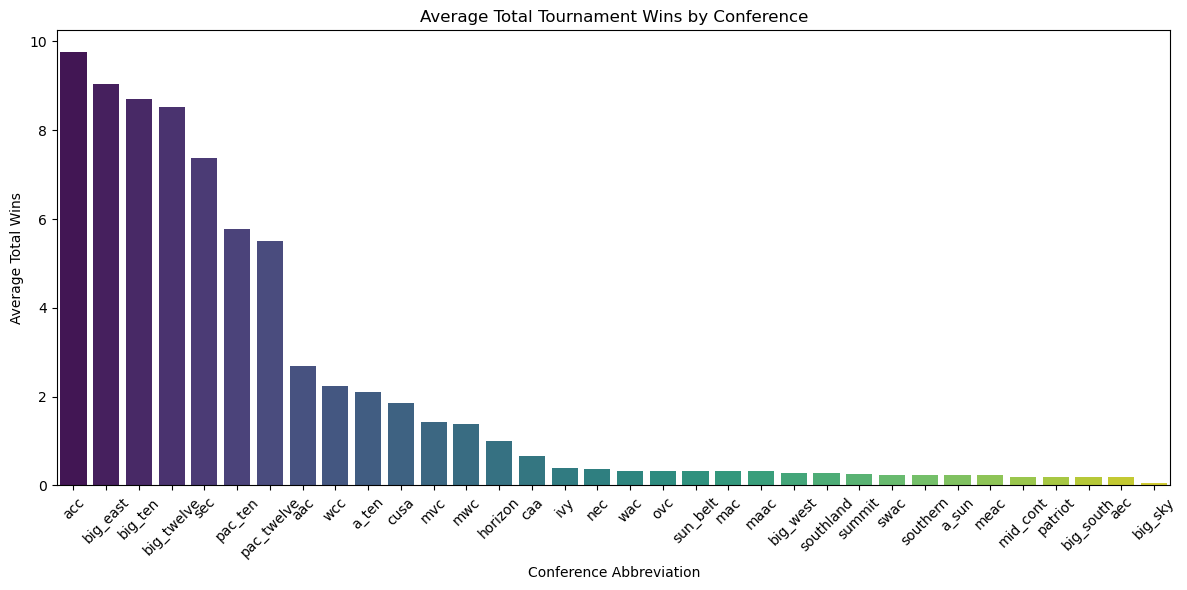

In [15]:
#Plot conf avg_total_wins
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by average total wins for clearer visualization
conf_avg_total_wins_sorted = conf_avg_total_wins.sort_values(by="avg_total_wins", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=conf_avg_total_wins_sorted, x="ConfAbbrev", y="avg_total_wins", palette="viridis")

# Customize plot
plt.title("Average Total Tournament Wins by Conference")
plt.xlabel("Conference Abbreviation")
plt.ylabel("Average Total Wins")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [16]:
#Add an opponent conf abbreviation category to our df along with opp representation and oppconfwins

#creating mapping of team to conference
copy_df = merge_tournament_results_copy.copy()

# build a mini‑lookup with exactly one row per (Season,TeamID)
lookup = (
    copy_df
      .loc[:, ['Season','TeamID','ConfAbbrev','conf_representation','avg_total_conf_wins']]
      .drop_duplicates()
      .rename(columns={
         'TeamID':                  'OppTeamID',
         'ConfAbbrev':              'OppConfAbbrev',
         'conf_representation':     'opp_conf_representation',
         'avg_total_conf_wins':     'opp_avg_total_conf_wins'
      })
)

# now left‑join it back on both Season and OppTeamID
copy_df = copy_df.merge(
    lookup,
    on=['Season','OppTeamID'],
    how='left'
)
copy_df.head()

# verify correct mapping by looking up teamid 1436
test_df = copy_df.query(
    "(TeamID == 1112 or OppTeamID == 1112) and Season == 2003"
)
test_df.head(15)

,Season,TeamID,OppTeamID,GameResult,Win,DiffMedianScoreDiff,DiffWinPercentage,DiffTeamMedFGM,DiffTeamMedFGA,DiffTeamMedFGM3,DiffTeamMedFGA3,DiffTeamMedFTM,DiffTeamMedFTA,DiffTeamMedOR,DiffTeamMedDR,DiffTeamMedAst,DiffTeamMedTO,DiffTeamMedStl,DiffTeamMedBlk,DiffTeamMedPF,DiffSeedAdjusted,ConfAbbrev,avg_total_conf_wins,conf_representation,OppConfAbbrev,opp_conf_representation,opp_avg_total_conf_wins
1,2003,1112,1436,W,1,7.0,0.237685,7.0,8.0,2.0,4.5,5.0,7.0,3.0,0.0,5.5,0.5,2.0,1.0,1.5,-15.0,pac_ten,5.777778,5,aec,1,0.190476
34,2003,1112,1211,W,1,5.0,0.150922,5.0,11.0,0.0,0.5,2.0,2.0,3.0,0.0,1.5,-0.5,2.0,1.0,-0.5,-8.0,pac_ten,5.777778,5,wcc,2,2.238095
66,2003,1112,1323,W,1,7.0,0.183180,3.0,5.0,-1.0,-2.5,1.0,4.0,3.0,-2.0,2.5,1.5,1.0,-1.0,1.5,-4.0,pac_ten,5.777778,5,big_east,4,9.047619
90,2003,1242,1112,W,1,3.0,-0.126190,1.0,-3.5,-2.5,-5.5,0.0,-2.0,0.0,1.0,-2.0,0.5,1.5,0.0,-0.5,1.0,big_twelve,8.523810,6,pac_ten,5,5.777778
91,2003,1436,1112,L,0,-7.0,-0.237685,-7.0,-8.0,-2.0,-4.5,-5.0,-7.0,-3.0,0.0,-5.5,-0.5,-2.0,-1.0,-1.5,15.0,aec,0.190476,1,pac_ten,5,5.777778
92,2003,1211,1112,L,0,-5.0,-0.150922,-5.0,-11.0,0.0,-0.5,-2.0,-2.0,-3.0,0.0,-1.5,0.5,-2.0,-1.0,0.5,8.0,wcc,2.238095,2,pac_ten,5,5.777778
93,2003,1323,1112,L,0,-7.0,-0.183180,-3.0,-5.0,1.0,2.5,-1.0,-4.0,-3.0,2.0,-2.5,-1.5,-1.0,1.0,-1.5,4.0,big_east,9.047619,4,pac_ten,5,5.777778
120,2003,1112,1242,L,0,-3.0,0.126190,-1.0,3.5,2.5,5.5,0.0,2.0,0.0,-1.0,2.0,-0.5,-1.5,0.0,0.5,-1.0,pac_ten,5.777778,5,big_twelve,6,8.523810


In [17]:
#Create differential between avg total confwerence wins and conf representation
copy_df["DiffConfRepresentation"] = copy_df["conf_representation"] - copy_df["opp_conf_representation"]
copy_df["DiffAvgTotalConfWins"] = copy_df["avg_total_conf_wins"] - copy_df["opp_avg_total_conf_wins"]

#Again, verify by taking a look at data 
copy_df.head()

#Reassign main df to our updated copy
merge_tournament_results_copy = copy_df

### Find the ratio between tournament performance and regular season performance grouped by Conference Representation:
Note: this was unused because I didn't feel confident in the results

In [18]:
#Find ratio between team regular season stats and team tournament stats based off total conference appearances

#First step, find mean regular season stats for num_teams, i.e. what is the mean score differential for teams whose conference only sent 1, 2, 3,... etc
#teams to the tournament 

CleanFeatures = [
    'TeamMedFGM',
    'TeamMedFGA',
    'TeamMedFGM3',
    'TeamMedFGA3',
    'TeamMedFTM',
    'TeamMedFTA',
    'TeamMedOR',
    'TeamMedDR',
    'TeamMedAst',
    'TeamMedTO',
    'TeamMedStl',
    'TeamMedBlk',
    'TeamMedPF',
]

conference_df = pd.read_csv(data_path + "MTeamConferences.csv")
regular_season_stats_agg = team_season_stats.merge(conference_df, 
                                             on=["Season", "TeamID"],
                                             how="left")

#print(regular_season_stats_agg)

#Create aggregate of team tournament stats
# Load tournament data
df_tournament_stats = pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv")

# Define column structure (same as regular season)
cols = ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

# Define reshaping dictionaries
winning_team_reshape_cols = [col for col in cols if col != "LTeamID"]
losing_team_reshape_cols = [col for col in cols if col != "WTeamID"]
win_pairs, lose_pairs = {}, {}

for col in winning_team_reshape_cols:
    if col == "WLoc":
        win_pairs[col] = "Location"
    elif col == "WTeamID":
        win_pairs[col] = "TeamID"
    elif col[0] == 'W':
        win_pairs[col] = col.replace("W", "Team")
    elif col[0] == 'L':
        win_pairs[col] = col.replace("L", "Opp")
    else:
        win_pairs[col] = col

for col in losing_team_reshape_cols:
    if col == "WLoc":
        lose_pairs[col] = "Location"
    elif col == "LTeamID":
        lose_pairs[col] = "TeamID"
    elif col[0] == 'L':
        lose_pairs[col] = col.replace("L", "Team")
    elif col[0] == 'W':
        lose_pairs[col] = col.replace("W", "Opp")
    else:
        lose_pairs[col] = col

# Reshape tournament data to team-level
df_team_tourney_results = pd.concat(
    [
        df_tournament_stats[winning_team_reshape_cols]
        .assign(GameResult="W")
        .rename(columns=win_pairs),
        df_tournament_stats[losing_team_reshape_cols]
        .assign(GameResult="L")
        .rename(columns=lose_pairs),
    ]
).reset_index(drop=True)

# Validate column presence
if "TeamID" not in df_team_tourney_results.columns:
    raise ValueError("TeamID not found in reshaped tournament data!")

# Feature engineering
df_team_tourney_results["ScoreDiff"] = (
    df_team_tourney_results["TeamScore"] - df_team_tourney_results["OppScore"]
)
df_team_tourney_results.drop(["TeamScore", "OppScore"], axis=1, inplace=True)
df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype("int")

# Final check
#print("Final team-level tournament DataFrame shape:", df_team_tourney_results.shape)
#print(df_team_tourney_results.sample(5, random_state=42))

# Aggregate stats per team per season
tournament_stats_agg = (
    df_team_tourney_results.groupby(["Season", "TeamID"])
    .agg(
        MedianScoreDiff=("ScoreDiff", "median"),
        WinPercentage=("Win", "mean"),
        TeamMedFGM=("TeamFGM", "median"),
        TeamMedFGA=("TeamFGA", "median"),
        TeamMedFGM3=("TeamFGM3", "median"),
        TeamMedFGA3=("TeamFGA3", "median"),
        TeamMedFTM=("TeamFTM", "median"),
        TeamMedFTA=("TeamFTA", "median"),
        TeamMedOR=("TeamOR", "median"),
        TeamMedDR=("TeamDR", "median"),
        TeamMedAst=("TeamAst", "median"),
        TeamMedTO=("TeamTO", "median"),
        TeamMedStl=("TeamStl", "median"),
        TeamMedBlk=("TeamBlk", "median"),
        TeamMedPF=("TeamPF", "median"),
    )
    .reset_index()
)

# View sample of aggregated tournament stats
#print("Aggregated tournament stats shape:", tournament_stats_agg.shape)

#Verify merging was correct by looking for a specific teamID, it should only show up once for each season
#print(tournament_stats_agg.query("TeamID == 1254"))
conference_df = pd.read_csv(data_path + "MTeamConferences.csv")
tournament_stats_agg = tournament_stats_agg.merge(conference_df, 
                                             on=["Season", "TeamID"],
                                             how="left")

# Create mapping of conferences 
season_conf_stats = tournament_stats_agg.groupby(["Season", "ConfAbbrev"]).agg(
    num_teams=('TeamID', 'nunique'),
).reset_index()

# Merge num_teams into tournament_stats_agg (on Season + ConfAbbrev)
tournament_stats_agg = tournament_stats_agg.merge(season_conf_stats[["Season", "ConfAbbrev", "num_teams"]],
                      on=["Season", "ConfAbbrev"], how="left")

median_tourney_stats = tournament_stats_agg.groupby("num_teams")[CleanFeatures].median().reset_index()

#Map regular season stats
# Get just the tournament teams' conferences
tourney_teams_with_conf = tournament_stats_agg[["Season", "TeamID"]].merge(
    conference_df, on=["Season", "TeamID"], how="left"
)

season_conf_num_teams = tourney_teams_with_conf.groupby(
    ["Season", "ConfAbbrev"]
).agg(num_teams=('TeamID', 'nunique')).reset_index()

regular_season_stats_agg = regular_season_stats_agg.merge(
    season_conf_num_teams, on=["Season", "ConfAbbrev"], how="left"
)

median_regular_season_stats = regular_season_stats_agg.groupby("num_teams")[CleanFeatures].median().reset_index()

In [19]:
#Print Median Regular Season Stats and Median Tourney Stats
print(median_regular_season_stats)
print(median_tourney_stats)

   num_teams  TeamMedFGM  TeamMedFGA  TeamMedFGM3  TeamMedFGA3  TeamMedFTM  \
0        1.0       24.00       56.00          6.5         19.0        13.0   
1        2.0       24.00       55.00          6.0         19.0        13.0   
2        3.0       24.50       56.00          6.0         19.0        14.0   
3        4.0       25.00       56.00          6.0         19.0        14.0   
4        5.0       25.00       56.00          6.5         19.0        14.0   
5        6.0       25.00       56.00          6.0         19.0        14.0   
6        7.0       25.50       57.00          7.0         19.5        14.0   
7        8.0       25.00       57.50          7.0         20.0        14.0   
8        9.0       26.00       57.50          7.0         20.5        13.0   
9       11.0       24.75       55.25          6.0         17.0        15.0   

   TeamMedFTA  TeamMedOR  TeamMedDR  TeamMedAst  TeamMedTO  TeamMedStl  \
0       19.00       10.0      23.00        12.0       13.0         

In [20]:
#Compute ratios between the two
# Step 1: Ensure sorted and aligned by num_teams
median_regular_season_stats = median_regular_season_stats.sort_values("num_teams").reset_index(drop=True)
median_tourney_stats = median_tourney_stats.sort_values("num_teams").reset_index(drop=True)

#Set num_teams as index to align
reg = median_regular_season_stats.set_index("num_teams")
tourney = median_tourney_stats.set_index("num_teams")

#Calculate ratio
ratio_stats = tourney / reg
ratio_stats.reset_index(inplace=True)

#fix columns
ratio_stats.rename(columns={col: col + "_Ratio" for col in ratio_stats.columns if col != "num_teams"}, inplace=True)

#print to visualize
print(ratio_stats.round(3))

#make csv, I originally planned to use the csv, but decided off on it
ratio_stats.to_csv('ratio_stats.csv', index=False)

   num_teams  TeamMedFGM_Ratio  TeamMedFGA_Ratio  TeamMedFGM3_Ratio  \
0          1             0.917             1.018              1.000   
1          2             0.969             1.036              1.000   
2          3             0.980             1.000              1.083   
3          4             1.000             1.018              1.083   
4          5             0.960             1.009              0.923   
5          6             1.000             1.000              1.000   
6          7             0.980             1.000              1.000   
7          8             0.990             0.991              0.893   
8          9             0.962             0.957              0.857   
9         11             0.929             0.950              1.000   

   TeamMedFGA3_Ratio  TeamMedFTM_Ratio  TeamMedFTA_Ratio  TeamMedOR_Ratio  \
0              1.105             0.846             0.842            0.950   
1              1.053             1.000             0.962        

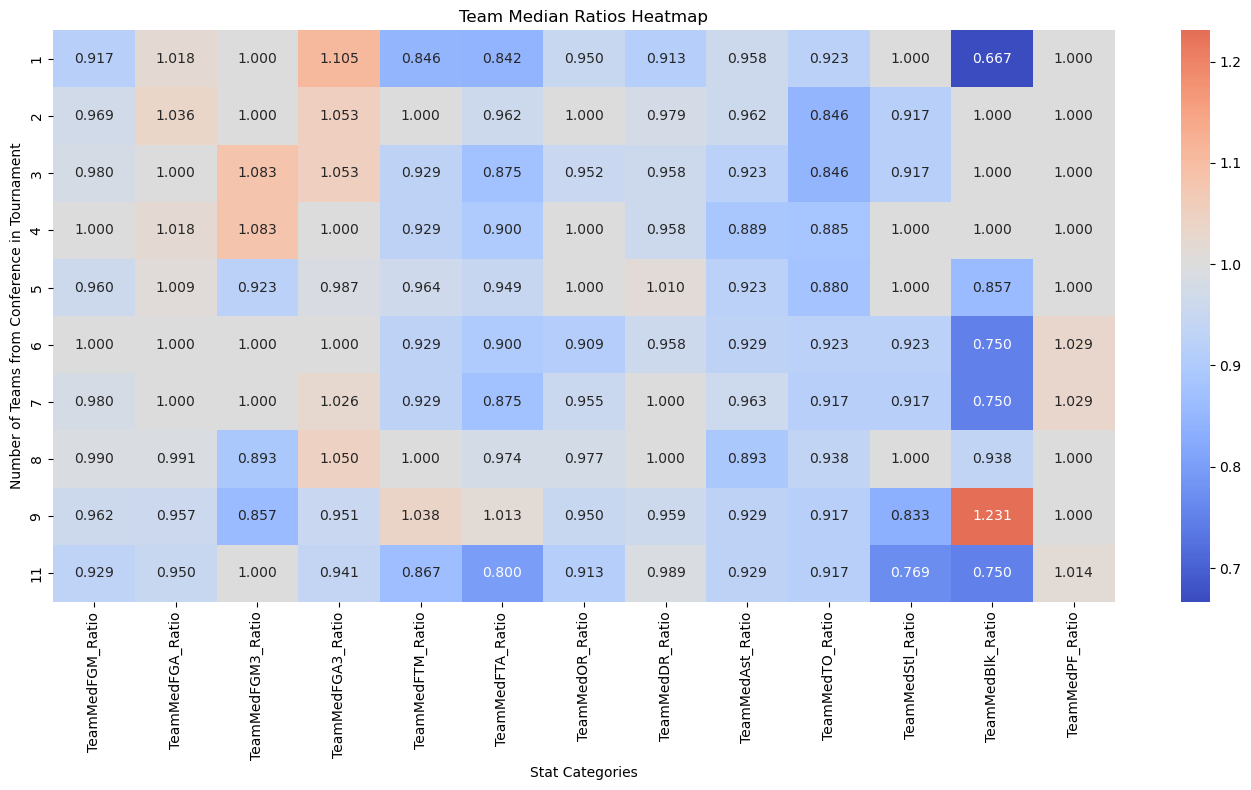

In [21]:
#Create heatmap of ratios
import seaborn as sns
import matplotlib.pyplot as plt
ratio_stats.set_index('num_teams', inplace=True)

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(ratio_stats, annot=True, fmt=".3f", cmap="coolwarm", center=1.0)

# Add title and axis labels
plt.title('Team Median Ratios Heatmap')
plt.xlabel('Stat Categories')
plt.ylabel('Number of Teams from Conference in Tournament')

plt.tight_layout()
plt.show()

In [22]:
#Print final training dataset w/ dropped repeated columns
final_df = merge_tournament_results_copy.copy()

final_df.drop(
    columns=[
        "conf_representation",
        "opp_conf_representation",
        "opp_avg_total_conf_wins",
        "avg_total_conf_wins"
    ],
    inplace=True
)

final_df.head()

,Season,TeamID,OppTeamID,GameResult,Win,DiffMedianScoreDiff,DiffWinPercentage,DiffTeamMedFGM,DiffTeamMedFGA,DiffTeamMedFGM3,DiffTeamMedFGA3,DiffTeamMedFTM,DiffTeamMedFTA,DiffTeamMedOR,DiffTeamMedDR,DiffTeamMedAst,DiffTeamMedTO,DiffTeamMedStl,DiffTeamMedBlk,DiffTeamMedPF,DiffSeedAdjusted,ConfAbbrev,OppConfAbbrev,DiffConfRepresentation,DiffAvgTotalConfWins
0,2003,1421,1411,W,1,-5.5,-0.151724,0.0,2.0,0.5,-2.0,-0.5,-7.0,-0.5,-2.5,-1.0,1.0,1.0,1.0,0.0,0.0,big_south,swac,0,-0.047619
1,2003,1112,1436,W,1,7.0,0.237685,7.0,8.0,2.0,4.5,5.0,7.0,3.0,0.0,5.5,0.5,2.0,1.0,1.5,-15.0,pac_ten,aec,4,5.587302
2,2003,1113,1272,W,1,-2.0,-0.172414,1.0,-4.0,-4.0,-8.0,1.0,0.0,0.0,-3.0,-1.0,1.0,-3.0,0.0,1.0,3.0,pac_ten,cusa,1,3.920635
3,2003,1141,1166,W,1,-6.0,-0.085684,-1.0,-4.0,0.0,-2.0,6.0,4.0,0.0,1.0,-3.0,5.0,-1.0,-2.0,4.0,5.0,mac,mvc,-1,-1.095238
4,2003,1143,1301,W,1,1.0,0.124138,3.5,6.0,-2.0,-3.5,-2.0,0.0,1.0,1.0,3.0,0.0,-0.5,1.0,0.0,-1.0,pac_ten,acc,1,-3.984127


### Create Visualizations for some feature Differentials:

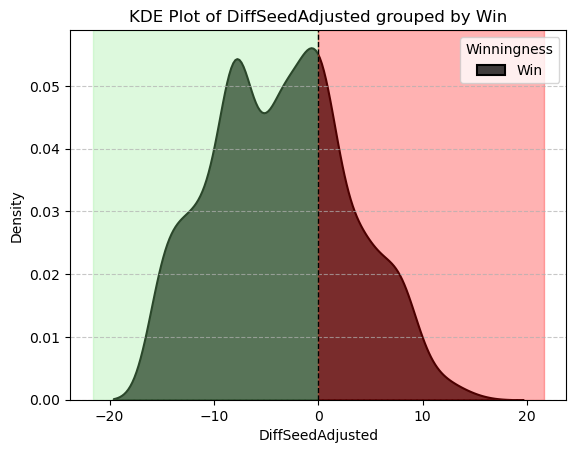

In [23]:
#Visualize density of seed feature
sns.kdeplot(
    data=final_df[final_df['Win'] == 1],
    x='DiffSeedAdjusted',
    fill=True,
    color='black',
    alpha=0.75,
    linewidth=1.5
)

#get data range
xmin, xmax = plt.xlim()

#shade left (teams that won with higher seed)
plt.axvspan(xmin, 0, color='lightgreen', alpha=0.3)

#shade right side (teams that won with a lower seed)
plt.axvspan(0, xmax, color='red', alpha=0.3)

#divided at x=0
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title('KDE Plot of DiffSeedAdjusted grouped by Win')
plt.xlabel('DiffSeedAdjusted')
plt.ylabel('Density')
plt.legend(['Win'], title="Winningness")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

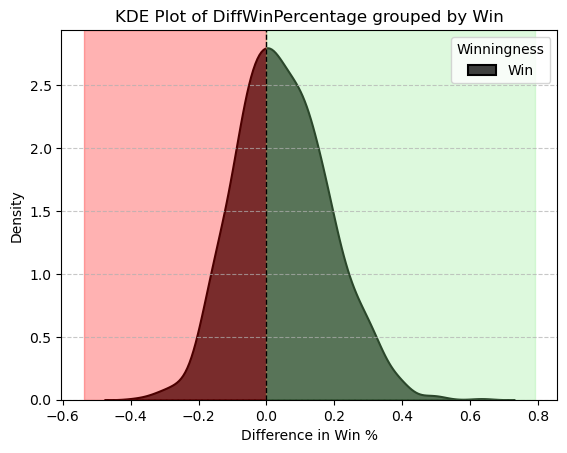

In [24]:
#Visualize density of win % feature
sns.kdeplot(
    data=final_df[final_df['Win'] == 1],
    x='DiffWinPercentage',
    fill=True,
    color='black',
    alpha=0.75,
    linewidth=1.5
)

#get data range
xmin, xmax = plt.xlim()

#shade left side (teams with lower win %)
plt.axvspan(xmin, 0, color='red', alpha=0.3)

#shade right side (teams w/ higher win %)
plt.axvspan(0, xmax, color='lightgreen', alpha=0.3)

#divided at x=0
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title('KDE Plot of DiffWinPercentage grouped by Win')
plt.xlabel('Difference in Win %')
plt.ylabel('Density')
plt.legend(['Win'], title="Winningness")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

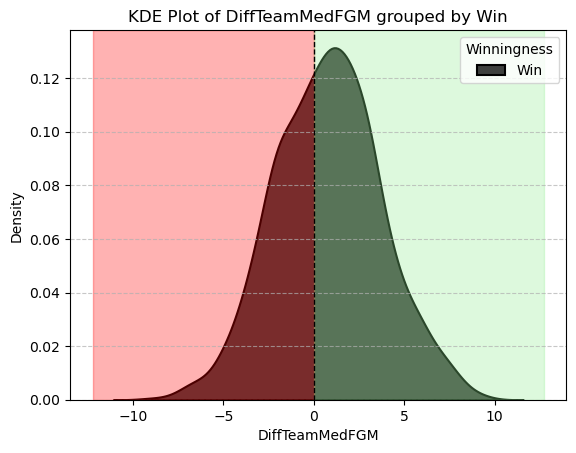

In [25]:
#Visualize density of seed feature
sns.kdeplot(
    data=final_df[final_df['Win'] == 1],
    x='DiffTeamMedFGM',
    fill=True,
    color='black',
    alpha=0.75,
    linewidth=1.5
)

#get data range
xmin, xmax = plt.xlim()

#shade left (teams that won with less median fgm)
plt.axvspan(xmin, 0, color='red', alpha=0.3)

#shade right side (teams that won with higher med fgm)
plt.axvspan(0, xmax, color='lightgreen', alpha=0.3)

#divided at x=0
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title('KDE Plot of DiffTeamMedFGM grouped by Win')
plt.xlabel('DiffTeamMedFGM')
plt.ylabel('Density')
plt.legend(['Win'], title="Winningness")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Create and train a neural network to predict game level team win or loss:
Train NN on 3 varying feature sets described in presentation, I include early stoppage, kfoldcrossvalidation, and randomize the data to ensure the order in which it's presented doesn't influence predictions

In [26]:
#Model #1 - Neural Network

#Import Libraries
import tensorflow as tf
from keras.models import Sequential
from keras import layers, models
from sklearn.model_selection import KFold
from keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler


#Print merge_tournament_results_copydf cols to ensure all the right ones are there
#print(merge_tournament_results_copy.columns)

#Define Features and Target Col
Features = [
    'DiffMedianScoreDiff',
    'DiffWinPercentage',
    'DiffTeamMedFGM',
    'DiffTeamMedFGA',
    'DiffTeamMedFGM3',
    'DiffTeamMedFGA3',
    'DiffTeamMedFTM',
    'DiffTeamMedFTA',
    'DiffTeamMedOR',
    'DiffTeamMedDR',
    'DiffTeamMedAst',
    'DiffTeamMedTO',
    'DiffTeamMedStl',
    'DiffTeamMedBlk',
    'DiffTeamMedPF',
    'DiffSeedAdjusted',
    "DiffConfRepresentation", 
    "DiffAvgTotalConfWins",
]


Target = ['Win']

#Model creation function
def create_model():
    model = tf.keras.models.Sequential()
    
    model.add(Input(shape=(len(Features),)))
    model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
    
    model.add(Dropout(0.4))
    
    model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation="sigmoid"))

    return model

2025-05-06 22:07:33.280489: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [27]:
#Implement early stopping
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

early_stopping = EarlyStopping(
    monitor='val_accuracy',      
    patience=15,                  
    restore_best_weights=True   
)

#Train model on 5 folds
X = merge_tournament_results_copy[Features]
Y = merge_tournament_results_copy[Target]

#Create results variables
reports = []
results_dict = {}

#Run model 30 times to get good overall metrics for entire dataset (6 * 5 folds)
for run in range(6):
    #Create kfolds w/ new randomstate each time
    folds =  KFold(n_splits=5, shuffle=True)
    for i, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[valid_index]
        
        #Scale X data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        model = create_model()
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        epochs = 50
        print_every_n_epochs = LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}/{epochs} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}") if (epoch + 1) % 10 == 0 or epoch == 0 else None
        )

        history = model.fit(x=X_train,
                            y=y_train, 
                            validation_data=(X_val,y_val), 
                            batch_size=32, 
                            epochs=epochs,
                            verbose=0,
                            callbacks=[print_every_n_epochs, early_stopping],
                            )

        # Generate classification report
        y_pred_prob = model.predict(X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)
        report = classification_report(y_val, y_pred, output_dict=True)
        reports.append(report)

        results_dict[f"fold_{i}"] = history.history

2025-05-06 22:07:40.813716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50 - loss: 0.7973 - accuracy: 0.5581 - val_loss: 0.6801 - val_accuracy: 0.6474
Epoch 10/50 - loss: 0.6086 - accuracy: 0.6992 - val_loss: 0.6004 - val_accuracy: 0.7089
Epoch 20/50 - loss: 0.5836 - accuracy: 0.7133 - val_loss: 0.5895 - val_accuracy: 0.7052
18/18 [==============================] - 0s 480us/step
Epoch 1/50 - loss: 0.7521 - accuracy: 0.5414 - val_loss: 0.6929 - val_accuracy: 0.6130
Epoch 10/50 - loss: 0.6030 - accuracy: 0.7065 - val_loss: 0.5888 - val_accuracy: 0.7034
Epoch 20/50 - loss: 0.5811 - accuracy: 0.7173 - val_loss: 0.5812 - val_accuracy: 0.7071
18/18 [==============================] - 0s 455us/step
Epoch 1/50 - loss: 0.7157 - accuracy: 0.6047 - val_loss: 0.6299 - val_accuracy: 0.6854
Epoch 10/50 - loss: 0.5881 - accuracy: 0.7087 - val_loss: 0.6043 - val_accuracy: 0.6872
18/18 [==============================] - 0s 457us/step
Epoch 1/50 - loss: 0.7253 - accuracy: 0.5726 - val_loss: 0.6585 - val_accuracy: 0.6582
Epoch 10/50 - loss: 0.5922 - accuracy: 0.7146 -

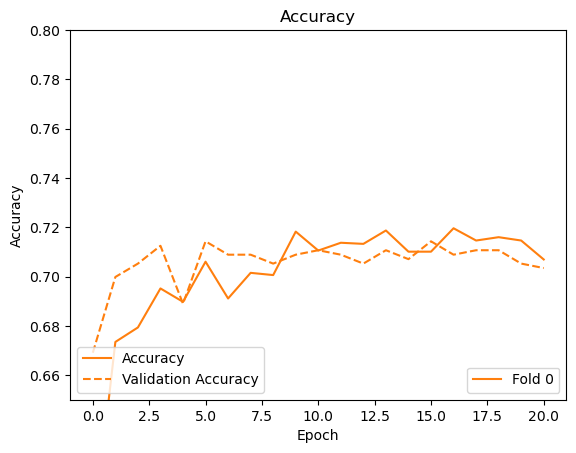

In [29]:
#Print plot of accurracy and validation accurracy (only for one instance, too many gets ugly)
#Note: these plots can be pretty variable as our dataset is small so the validation jumps quite a bit
fig, ax = plt.subplots()

lines = []
for i, history in enumerate(results_dict):
    if (i != 1): continue
    color = f"C{i}"
    l0, = ax.plot(results_dict[history]["accuracy"], color=color, linestyle="-")
    l1, = ax.plot(results_dict[history]["val_accuracy"], color=color, linestyle="--")

    lines.append(l0)
    lines.append(l1)

# add formatting
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim((0.65, 0.8))
first_legend = ax.legend(lines[:2], ["Accuracy", "Validation Accuracy"], loc="lower left")
ax.add_artist(first_legend)
second_legend = ax.legend(lines[::2], ["Fold 0", "Fold 1", "Fold 2", "Fold 3", "Fold 4"], loc="lower right")

plt.show()

In [30]:
#print avg accurracy, avg recall (for both), and avg precision (for both)
avg_acc = 0
avg_recall = 0
avg_precision = 0
total = len(reports)

#total acc, recall, and precision
for report in reports:
    avg_acc += report["accuracy"]
    avg_recall += report["macro avg"]["recall"]
    avg_precision += report["macro avg"]["precision"]

#divide by number of reports
avg_acc /= total
avg_recall /= total
avg_precision /= total

#print outputs
print("avg_acc: ", avg_acc)
print("avg_recall: ", avg_recall)
print("avg_precision: ", avg_precision)
print("total reports: ", total)

avg_acc:  0.7113467603148395
avg_recall:  0.7112467055323732
avg_precision:  0.7126213029928067
total reports:  30


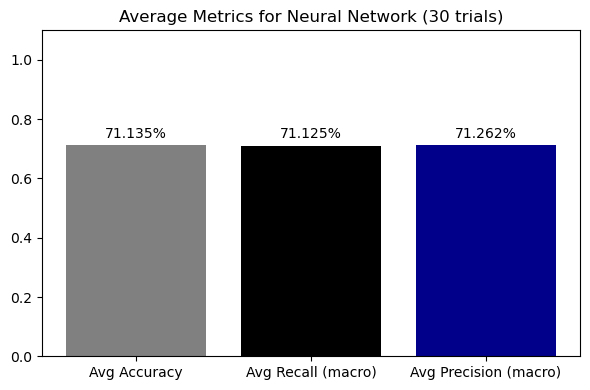

In [31]:
#make bar plot of avg_acc, avg_recall, and avg_precision
labels = ["Avg Accuracy", "Avg Recall (macro)", "Avg Precision (macro)"]
values = [avg_acc, avg_recall, avg_precision]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=["grey", "black", "darkblue"])

#Add percentage labels on top
ax.bar_label(bars, labels=[f"{v*100:.3f}%" for v in values], padding=3) #percentage bar code sourced form chatgpt

ax.set_ylim(0, 1.1)
ax.set_title("Average Metrics for Neural Network (30 trials)")
plt.tight_layout()
plt.show()

### Create Logistic Regression Model w/ Same Goal as Above:


In [32]:
#Logistic Regression Model Approach
from sklearn.linear_model import LogisticRegression

#Train model on 5 folds
X = merge_tournament_results_copy[Features]
Y = merge_tournament_results_copy[Target]

#Create result vars
reports = []
model_coefficients = []

#Reproduce results 30 times
for run in range(6):
    #Create randomized kfolds
    folds =  KFold(n_splits=5, shuffle=True)

    for i, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[valid_index]
        
        #Scale X data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        #Define logreg model
        model = LogisticRegression(
            penalty="l1", 
            solver="liblinear", 
            C=1.0, 
        )
        #Fit model to data
        model.fit(X_train, y_train.values.ravel())

        #Generate predictions and classification report
        y_pred = model.predict(X_val)
        report = classification_report(y_val, y_pred, output_dict=True)
        reports.append(report)

        #Get model coefficients to see which ones have highest impact
        coefficients = pd.DataFrame({
            "Feature": X.columns,
            "Coefficient": model.coef_[0]
        })
        model_coefficients.append(coefficients)

In [33]:
#print avg accurracy, avg recall (for both), and avg precision (for both)
avg_acc = 0
avg_recall = 0
avg_precision = 0
total = len(reports)

#total acc, recall, and precision
for report in reports:
    avg_acc += report["accuracy"]
    avg_recall += report["macro avg"]["recall"]
    avg_precision += report["macro avg"]["precision"]

#divide by number of reports
avg_acc /= total
avg_recall /= total
avg_precision /= total

#print outputs
print("avg_acc: ", avg_acc)
print("avg_recall: ", avg_recall)
print("avg_precision: ", avg_precision)
print("total reports: ", total)

avg_acc:  0.7145437490718174
avg_recall:  0.7146100143019228
avg_precision:  0.7146199384309202
total reports:  30


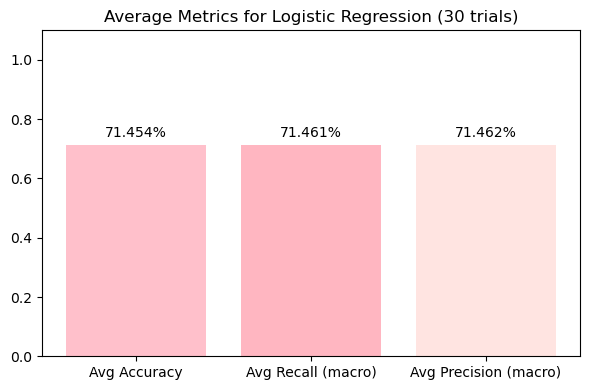

In [34]:
#make bar plot of avg_acc, avg_recall, and avg_precision
labels = ["Avg Accuracy", "Avg Recall (macro)", "Avg Precision (macro)"]
values = [avg_acc, avg_recall, avg_precision]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=["pink", "lightpink", "mistyrose"])

#Add percentage labels on top
ax.bar_label(bars, labels=[f"{v*100:.3f}%" for v in values], padding=3) #percentage bar code sourced form chatgpt

ax.set_ylim(0, 1.1)
ax.set_title("Average Metrics for Logistic Regression (30 trials)")
plt.tight_layout()
plt.show()

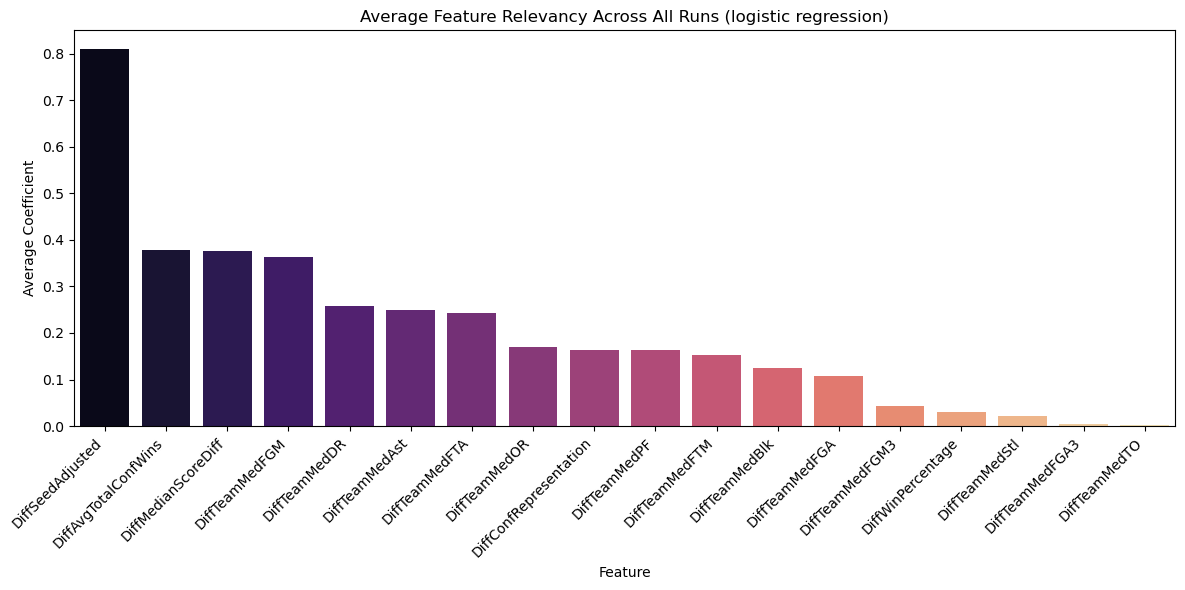

In [35]:
#Graph feature relevancy
all_feature_importances = pd.concat(model_coefficients, ignore_index=True)

# Group by feature name and compute the mean coefficient
avg_importance = all_feature_importances.groupby("Feature")["Coefficient"].mean().abs().reset_index()

# Sort for nicer plotting
avg_importance = avg_importance.sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_importance, x="Feature", y="Coefficient", palette="magma")

# Customize
plt.title("Average Feature Relevancy Across All Runs (logistic regression)")
plt.xlabel("Feature")
plt.ylabel("Average Coefficient")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Do same w/ XGBOOST MODEL:
Note, no scaling was needed as this is a tree based model

In [36]:
#XGBOOST CLASSIFIER MODEL 
import xgboost as xgb
from sklearn.metrics import log_loss

#Train model on 5 folds
X = merge_tournament_results_copy[Features]
Y = merge_tournament_results_copy[Target]

#Create result vars
reports = []
feature_importance = []

#Repeat experiment 30 times
for run in range(6):
    print("Run: ", run)
    #Create kfolds
    folds =  KFold(n_splits=5, shuffle=True)
    for i, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[valid_index]

        #Define xgboost model
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            n_estimators=500,
            learning_rate=0.01,
            max_depth=3,
        )

        #Fit model to data
        model.fit(X_train, y_train.values.ravel())

        #Generate predictions and classification report
        y_pred_prob = model.predict(X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)
        report = classification_report(y_val, y_pred, output_dict=True)
        reports.append(report)

        #Add feature importances to array
        fet_importance = pd.DataFrame({
            "Feature": X.columns,
            "Coefficient": model.feature_importances_
        })
        feature_importance.append(fet_importance)

print("DONE")

Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Run:  5
DONE


In [37]:
#print avg accurracy, avg recall (for both), and avg precision (for both)
avg_acc = 0
avg_recall = 0
avg_precision = 0
total = len(reports)

#total acc, recall, and precision
for report in reports:
    avg_acc += report["accuracy"]
    avg_recall += report["macro avg"]["recall"]
    avg_precision += report["macro avg"]["precision"]

#divide by number of reports
avg_acc /= total
avg_recall /= total
avg_precision /= total

#print outputs
print("avg_acc: ", avg_acc)
print("avg_recall: ", avg_recall)
print("avg_precision: ", avg_precision)
print("total reports: ", total)

avg_acc:  0.6984456761974648
avg_recall:  0.6983642210149471
avg_precision:  0.6984601381280141
total reports:  30


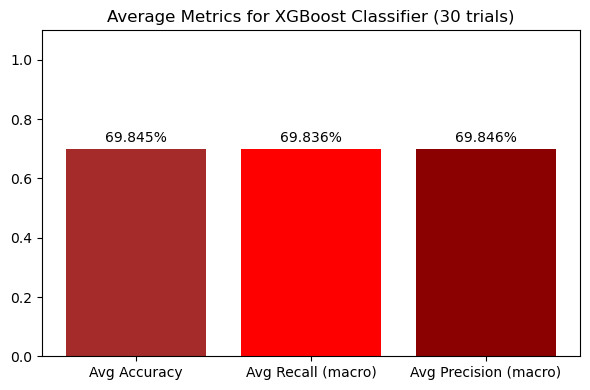

In [38]:
#make bar plot of avg_acc, avg_recall, and avg_precision
labels = ["Avg Accuracy", "Avg Recall (macro)", "Avg Precision (macro)"]
values = [avg_acc, avg_recall, avg_precision]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=["brown", "red", "darkred"])

#Add percentage labels on top
ax.bar_label(bars, labels=[f"{v*100:.3f}%" for v in values], padding=3) #percentage bar code sourced form chatgpt

ax.set_ylim(0, 1.1)
ax.set_title("Average Metrics for XGBoost Classifier (30 trials)")
plt.tight_layout()
plt.show()

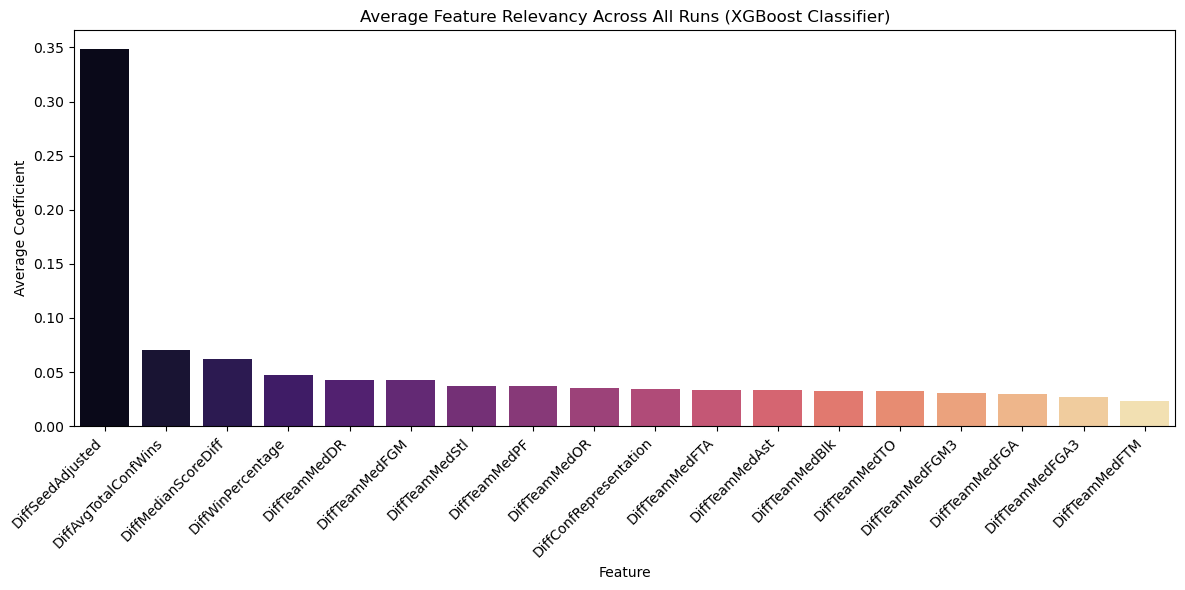

In [39]:
#Graph feature relevancy
all_feature_importances = pd.concat(feature_importance, ignore_index=True)

# Group by feature name and compute the mean coefficient
avg_importance = all_feature_importances.groupby("Feature")["Coefficient"].mean().reset_index()

# Sort for nicer plotting
avg_importance = avg_importance.sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_importance, x="Feature", y="Coefficient", palette="magma")

# Customize
plt.title("Average Feature Relevancy Across All Runs (XGBoost Classifier)")
plt.xlabel("Feature")
plt.ylabel("Average Coefficient")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#It seems like our model is really only valueing the difference in seed
#I believe by finding a way to adjust our statistics to be more conference
#based, i.e. teams from stronger conferences are given higher stats
#we can get better overall results and have our model value the 
#in game statistics a bit more

#Lets figure out whether we can get an empirical mapping for this
#change, first i'm going to map the number of teams that made
#the tournament on the x and the total number of wins on the y

#This was implemented above